### Reads

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from DeepRetail.evaluation.metrics import rmsse, scaled_error, mape, rmse, mse, mase
from DeepRetail.evaluation.base import Evaluator
from DeepRetail.forecasting.statistical import StatisticalForecaster
from DeepRetail.transformations.formats import transaction_df

/home/filtheo/DeepRetail/.venv/lib/python3.8/site-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
df = pd.read_csv('/home/filtheo/DeepRetail/DeepRetail/data/data_folder/motors_month.csv', index_col=0)
df.head()

,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,...,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30
unique_id,,,,,,,,,,,,,,,,,,,,,
Audi A1,2.0,21.0,9.0,3.0,5.0,2.0,2.0,1.0,1.0,1.0,...,2.0,0.0,3.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0
Audi A3,6.0,45.0,20.0,23.0,13.0,11.0,8.0,9.0,7.0,13.0,...,11.0,6.0,6.0,3.0,2.0,2.0,4.0,2.0,1.0,1.0
Audi A4,15.0,60.0,29.0,26.0,16.0,26.0,17.0,13.0,7.0,14.0,...,8.0,2.0,6.0,2.0,1.0,0.0,2.0,2.0,0.0,2.0
Audi A5,2.0,11.0,8.0,5.0,4.0,4.0,7.0,7.0,1.0,3.0,...,2.0,2.0,2.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0
Audi A6,6.0,30.0,8.0,9.0,5.0,8.0,11.0,3.0,4.0,5.0,...,1.0,6.0,8.0,4.0,2.0,0.0,3.0,1.0,2.0,0.0


In [4]:
# convert columns to datetime
df.columns = pd.to_datetime(df.columns)

# Drop columns with only nans
df = df.dropna(axis = 0, how = 'all')
df = df.fillna(0)

# Drop rows with only zeros
df = df.loc[~(df==0).all(axis=1)]

# Drop the last month cuz its incomplete
df = df.drop(df.columns[-1], axis = 1)

In [5]:
# Count non zero observations per row on df
non_zero_obs = df.astype(bool).sum(axis=1)

# Total series with over 5 non zero observations
print(len(non_zero_obs))
len(non_zero_obs[non_zero_obs > 5])

83


69

In [6]:
# Filter df to only include series with over 5 non zero observations
sample_df = df.loc[non_zero_obs[non_zero_obs > 5].index]
sample_df.shape

(69, 64)

In [7]:
# Define some parameters
freq = 'M'
holdout = True
h = 6
cv = 4
total_test_lenght = h + cv - 1 
models = ['Naive', 'SNaive', 'CrostonOptimized']

# Define metrics
metrics = [rmsse, scaled_error, mape, rmse, mase]

#### Extract features for the clustering

In [8]:
from tsfeatures import tsfeatures
from DeepRetail.forecasting.utils import get_numeric_frequency
from sklearn.preprocessing import StandardScaler

In [9]:
def stability_features(x: np.array, freq: int = 1):
    """Stability.

    Parameters
    ----------
    x: numpy array
        The time series.
    freq: int
        Frequency of the time series

    Returns
    -------
    dict
        'stability': Variance of the means of tiled windows.
    """
    if freq == 1:
        width = 10
    else:
        width = freq

    nr = len(x)
    lo = np.arange(0, nr, width)
    up = lo + width
    nsegs = nr / width

    # Get the mean of the segments
    meanx = [np.nanmean(x[lo[idx]:up[idx]]) for idx in np.arange(int(nsegs))]
    # get the variance of the means
    varx = [np.nanvar(x[lo[idx]:up[idx]]) for idx in np.arange(int(nsegs))]


    if len(x) < 2 * width:
        stability = 0
    else:
        Lshift = np.nanmean(meanx)
        VARshift = np.nanmean(varx)

    return {'Vchange': VARshift, 'Lchange': Lshift}

In [10]:
# convert to transaction format
t_df = transaction_df(sample_df)

# Estimate the features
features = tsfeatures(t_df, freq=get_numeric_frequency(freq)).set_index('unique_id')

# Mean and variance
extra_feat = t_df.groupby('unique_id').agg({'y':['mean','std']}).droplevel(0, axis = 1)

# Merge the features
features = features.merge(extra_feat, left_index = True, right_index = True)

# Estimate the stability features
stability = t_df.groupby('unique_id').agg({'y':stability_features})

# extract the values of the dictionary on column y on extra columns
stability = stability['y'].apply(pd.Series)

# Merge the features
features = features.merge(stability, left_index = True, right_index = True)

In [11]:
# groupby and drop the y double column
cols = ['mean','std',  'e_acf1', 'trend', 'linearity', 'curvature', 'seasonal_strength',
        'peak', 'trough', 'entropy', 'lumpiness', 'spike',  'Vchange', 'Lchange']

# cols = ['mean','std', 'e_acf1', 'trend', 'linearity', 'curvature', 'seasonal_strength',
#        'peak', 'trough', 'entropy', 'lumpiness', 'spike', 'crossing_points', 'Vchange', 'Lchange']


features_ = features[cols]

In [12]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(features_)
data_scaled = pd.DataFrame(data_scaled, columns=features_.columns, index = features_.index)

#### Hierarchical Clustering

In [13]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from collections import defaultdict

In [14]:
# Compute the linkage matrix using 'ward' linkage and 'euclidean' distance metric
linkage_matrix = linkage(data_scaled, method='ward', metric='euclidean')

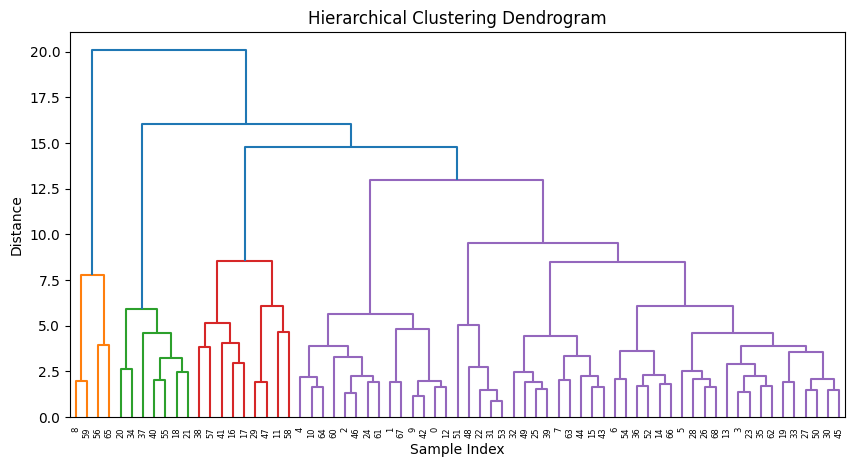

In [15]:

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [16]:
# sort the linkage matrix based on distance
idx = np.argsort(linkage_matrix[:, 2])
sorted_l = linkage_matrix[idx]

# Bin the distances into n parts
n = 6
bins = np.linspace(0, sorted_l[-1, 2], n)
labels = np.arange(1, n + 1)

bins

array([ 0.        ,  4.01337049,  8.02674097, 12.04011146, 16.05348195,
       20.06685244])

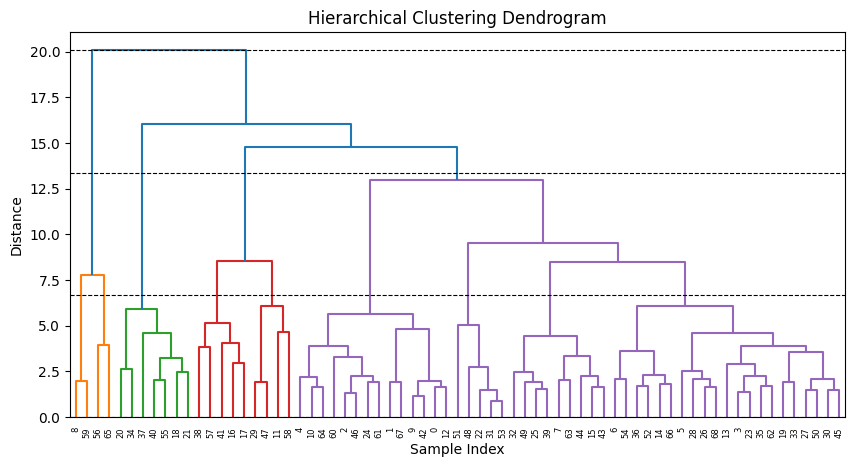

In [17]:
# Bin the distances into n parts
n = 4
bins = np.linspace(0, sorted_l[-1, 2], n)
labels = np.arange(1, n + 1)


# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
for i in bins:
    # draw a horizonta line 
    plt.axhline(y=i, c='k', linestyle='dashed', linewidth = 0.8)


plt.show()

In [18]:
n_levels = 4



# Step 1: Calculate the linkage matrix
linkage_matrix = linkage(data_scaled, method='ward', metric='euclidean')

# Step 2: Sort by distance
sorted_linkage = linkage_matrix[linkage_matrix[:, 2].argsort()]

# Step 3: Initialize binning
distances = sorted_linkage[:, 2]
bin_edges = np.linspace(0, np.max(distances), n_levels)

hierarchical_structure = {i: [i] for i in range(data_scaled.shape[0])}
hierarchical_df = pd.DataFrame(index=data_scaled.index)
next_cluster_id = data_scaled.shape[0]

# Initialize current level
current_level = 1

for i in range(len(bin_edges) - 1):
    lower_edge, upper_edge = bin_edges[i], bin_edges[i + 1]

    # For the columns on the df
    level_column = f'level_{current_level}'
    cluster_count = 0

    
    for row in sorted_linkage:
        dist = row[2]
        if dist >= lower_edge and dist < upper_edge:
            cluster1, cluster2 = int(row[0]), int(row[1])
            new_cluster = hierarchical_structure[cluster1] + hierarchical_structure[cluster2]
            
            # Update the hierarchical structure
            hierarchical_structure[next_cluster_id] = new_cluster

            # Update DataFrame with the new cluster ID
            for idx in new_cluster:
                unique_id = df.index[idx]
                hierarchical_df.loc[unique_id, level_column] = next_cluster_id
            
            # Update existing clusters to new merged cluster
            for c in new_cluster:
                hierarchical_structure[c] = new_cluster

            cluster_count += 1  # Increment the cluster count for this bin
            next_cluster_id += 1

    current_level += 1  # Increment the current level

    
hierarchical_df

,level_1,level_2,level_3
unique_id,,,
Audi A1,125.0,133.0,135.0
Audi A3,125.0,133.0,135.0
Audi A4,125.0,133.0,135.0
Audi A5,128.0,133.0,135.0
Audi A6,125.0,133.0,135.0
...,...,...,...
Audi Tts,127.0,131.0,135.0
Audi A8L,118.0,133.0,135.0
Audi Rs4,126.0,NaN,135.0


In [19]:
# Generalize it!

In [20]:
from collections.abc import Iterable
def flatten(nested_list):
    """Flatten a nested list and yield only integers."""
    for item in nested_list:
        if isinstance(item, Iterable) and not isinstance(item, str):
            yield from flatten(item)  # Recursive call
        elif isinstance(item, int):  # Only yield integers
            yield item

In [21]:
def build_hierarchical_levels(df, n_levels):
    """
    Revised function to perform hierarchical clustering and generate a dataframe that maps each time series to its cluster at each level.
    Cluster labels are integers, unique within each level.
    
    Parameters:
    - df (DataFrame): The dataframe containing features for clustering.
    - n_levels (int): The number of hierarchical levels.
    
    Returns:
    - mapping_df (DataFrame): DataFrame containing mapping from unique_id to clusters at each level.
    """

    # Step 1: Calculate the linkage matrix
    linkage_matrix = linkage(df, method='ward', metric='euclidean')

    # Sort the linkage matrix by distance
    sorted_linkage_matrix = linkage_matrix[linkage_matrix[:, 2].argsort()]

    # Create bins for hierarchical levels
    distance_col = sorted_linkage_matrix[:, 2]
    bins = np.linspace(distance_col.min(), distance_col.max(), n_levels + 1)

    # Initialize a DataFrame to store the mapping from unique_id to clusters at each level
    mapping_df = pd.DataFrame({'unique_id': df.index})

    # Initialize current clusters with individual time series
    current_clusters = {i: [i] for i in range(len(df))}

    # Initialize cluster assignments at each level for each index
    # In which cluster is each time series at each level?

    # Itterate over the levels
    for current_level in range(n_levels):

        # take the lower and upper edge of the bin
        lower_edge, upper_edge = bins[current_level], bins[current_level + 1]

        # Initialize new clusters
        new_clusters = {}

        # Itterate over the rows of the linkage matrix
        for row in sorted_linkage_matrix:
            cluster_1, cluster_2, distance, _ = row

            # If the distance is within the bin
            if distance >= lower_edge and distance < upper_edge:
        
                # Merge clusters if they are different otherwise add only one instance of both if they are the same
                merged_cluster = [current_clusters[cluster_1], current_clusters[cluster_2]] if cluster_1 != cluster_2 else [cluster_1]
                # merged_cluster = current_clusters.pop(cluster_1, []) + current_clusters.pop(cluster_2, [])
                # Get a new cluster id
                new_cluster_id = len(current_clusters)
                # Update the current and the new clusters
                current_clusters[new_cluster_id] = list(flatten(merged_cluster))
                new_clusters[new_cluster_id] = list(flatten(merged_cluster))

        # sort the new_clusters basedon the lenght of the values. Longer should be first
        new_clusters = {k: v for k, v in sorted(new_clusters.items(), key=lambda item: len(item[1]))}

        # If new_clusters is empty we move to the next level
        if len(new_clusters) == 0:
            if len(mapping_df[f'level_{current_level}'].unique()) == 1:
                break
            else:
                # The new column is the same with the old
                mapping_df[f'level_{current_level + 1}'] = mapping_df[f'level_{current_level}']
                continue
        else:
        # For every new cluster, take the values and update the mapping_df column with the current level
        # If a row has already been assigned to a class (from a bigger cluster), it will not be updated
        # If a row has no cluster at this level, it will be assigned to a new cluster (the next one)
            for cluster_id, cluster in new_clusters.items():
                mapping_df.loc[cluster, f'level_{current_level + 1}'] = cluster_id

            # If we are on a level higher than 0 fill nans with values from the previous level
            if current_level > 0:
                mapping_df[f'level_{current_level + 1}'] = mapping_df[f'level_{current_level + 1}'].fillna(mapping_df[f'level_{current_level}'])
            else:
                # Fill nans with a new cluster id
                mapping_df[f'level_{current_level + 1}'] = mapping_df[f'level_{current_level + 1}'].fillna(mapping_df[f'level_{current_level + 1}'].max() + 1)

    # if all values on the last level are not the same, create a new level with a new cluster with the same values. The higher cluster_id
    last_col = mapping_df.columns[-1]
    if len(mapping_df[last_col].unique()) > 1:
        mapping_df[f'level_{n_levels + 1}'] = mapping_df[last_col].max() + 1
        mapping_df[f'level_{n_levels}'] = mapping_df[f'level_{n_levels + 1}']

    # Convert all values on the level columns to integers
    mapping_df[[f'level_{i}' for i in range(1, n_levels + 1)]] = mapping_df[[f'level_{i}' for i in range(1, n_levels + 1)]].astype(int)

    # If there are two identical columns, keep only one
    mapping_df = mapping_df.loc[:,~mapping_df.columns.duplicated()]

    # Now create a new column that joins all values from the levels with _
    mapping_df['new_unique_id'] = mapping_df[[f'level_{i}' for i in range(1, n_levels + 1)]].astype(str).agg('_'.join, axis=1)

    # Add the unique_id too in the start
    mapping_df['new_unique_id'] = mapping_df['unique_id'] + '_' + mapping_df['new_unique_id']

    # Drop all columns with that have the "level" string
    cols = [col for col in mapping_df.columns if 'level' in col]
    mapping_df = mapping_df.drop(cols, axis=1)

    return mapping_df


In [22]:
build_hierarchical_levels(data_scaled, 10)

,unique_id,new_unique_id
0,Audi A1,Audi A1_89_89_125_125_125_125_133_135_135_136
1,Audi A3,Audi A3_85_85_125_125_125_125_133_135_135_136
2,Audi A4,Audi A4_99_115_125_125_125_125_133_135_135_136
3,Audi A5,Audi A5_97_119_128_130_132_132_133_135_135_136
4,Audi A6,Audi A6_96_115_125_125_125_125_133_135_135_136
...,...,...
64,Volkswagen T-Roc,Volkswagen T-Roc_96_115_125_125_125_125_133_13...
65,Volkswagen Tiguan,Volkswagen Tiguan_106_116_116_129_129_129_129_...
66,Volkswagen Touareg,Volkswagen Touareg_100_112_128_130_132_132_133...
67,Volkswagen Touran,Volkswagen Touran_85_85_125_125_125_125_133_13...


In [23]:
# We have the issue with the bins not being dynamicaly updated
# We need a more smooth transition between the bins

In [24]:
# First column is the index of the first cluster
# Second column is the index of the second cluster

#### Hierarhical Forecasting

In [40]:
from DeepRetail.reconciliation.cross_sectional import CHieF, CrossSectionalReconciler
from DeepRetail.transformations.formats import hierarchical_to_transaction, extract_hierarchical_structure
from DeepRetail.evaluation.base import Evaluator
# Import metrics for evaluation
from DeepRetail.evaluation.metrics import rmsse, scaled_error, mape, rmse, mse, mase
from DeepRetail.reconciliation.utils import get_factors


In [20]:
# Define metrics
metrics = [rmsse, scaled_error, mape, rmse, mase]

In [ ]:
# We have developed the features for clustering
# now lets do the hierarhical forecasting

In [316]:
level_canditates = np.arange(2,12)

# Initialize a dictionary with the scores
scores = {}

for level in level_canditates:

    # build the hierarchical levels and get a copy of the original df
    mapping_df = build_hierarchical_levels(data_scaled, level)
    temp_df = sample_df.copy()

    # Map the index from mapping_df to the new index on sample_df
    mapping_df = mapping_df.set_index('unique_id')
    mapping_df = mapping_df['new_unique_id'].to_dict()
    temp_df.index = temp_df.index.map(mapping_df)

    # Initialize the arguments for hierarhical forecasting
    current = ['Bottom'] + ['level_' + str(i) for i in range(1, level + 1)]
    correct = current.copy()
    splitter = '_'
    total = False
    model = 'ETS'
    method = 'struc'

    # Define CHieF
    chief = CHieF(bottom_level_freq = freq, h=h, holdout = holdout, cv = cv)

    # Fit CHieF -> builds the hierarchical format
    chief.fit(df = temp_df, current_format=current, corrected_format=correct, splitter=splitter, add_total = total, format = 'pivoted')

    # Base forecasts + reconciliation
    base_forecasts_ets = chief.predict(models = model)
    reconciled_forecasts_2 = chief.reconcile(method = method)

    # Rename column y_pred to y
    reconciled_forecasts_2 = reconciled_forecasts_2.rename(columns = {'y_pred':'y'})
    # Add the cross-sectional-level column indicating the hierarchica level
    rec_extended = hierarchical_to_transaction(reconciled_forecasts_2, chief.hierarchical_format, sort_by = False, format = 'transaction')

    # keep only the bottom level
    rec_extended = rec_extended.loc[rec_extended['cross_sectional_level'] == 'Bottom']

    # Split the unique_id on _ and keep the last part
    rec_extended['unique_id'] = rec_extended['unique_id'].apply(lambda x: x.split('_')[-1])

    # Evaluate
    evaluator = Evaluator(sample_df, rec_extended, freq = freq, format = 'pivoted')
    eval_df_new = evaluator.evaluate(metrics = metrics).set_index('unique_id')

    scores[level] = eval_df_new['rmsse'].mean()
    
    

In [317]:
scores

{2: 1.6981765883576716,
 3: 1.7206554815732664,
 4: 2.006080486016169,
 5: 1.6563627393449716,
 6: 1.807019342176832,
 7: 1.8359597160397036,
 8: 1.638258556187732,
 9: 1.6087130895060455,
 10: 1.6467272712638121,
 11: 1.612645057844175}

In [25]:
scores = {2: 1.6981765883576716,
 3: 1.7206554815732664,
 4: 2.006080486016169,
 5: 1.6563627393449716,
 6: 1.807019342176832,
 7: 1.8359597160397036,
 8: 1.638258556187732,
 9: 1.6087130895060455,
 10: 1.6467272712638121,
 11: 1.612645057844175}

In [31]:
# Get the minimum key and value from the dictionary
min(scores.values())

1.6087130895060455

#### Try with Kmeans

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [ ]:
# with kmeans we only have a single intermittent level!

In [26]:
# Find the best number of clusters!
range_n_clusters = list(range(5,11))

sse_important = {}
silhouette_scores_important = {}

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(data_scaled)
    
    sse_important[n_clusters] = kmeans.inertia_
    silhouette_scores_important[n_clusters] = silhouette_score(data_scaled, kmeans_labels)


# Best number is the one with the maximum score!
best_n_clusters = max(silhouette_scores_important, key=silhouette_scores_important.get)
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(data_scaled)

For n_clusters = 2 The average silhouette_score is : 0.27955042821603904
For n_clusters = 3 The average silhouette_score is : 0.2323463096540762
For n_clusters = 4 The average silhouette_score is : 0.23790585455669308
For n_clusters = 5 The average silhouette_score is : 0.2093823249414319
For n_clusters = 6 The average silhouette_score is : 0.18126337918386107
For n_clusters = 7 The average silhouette_score is : 0.20463775648635996
For n_clusters = 8 The average silhouette_score is : 0.20717976332637364
For n_clusters = 9 The average silhouette_score is : 0.2107520482153682
For n_clusters = 10 The average silhouette_score is : 0.1887792905662054
For n_clusters = 11 The average silhouette_score is : 0.20372302589698477
For n_clusters = 12 The average silhouette_score is : 0.2000640901755853
For n_clusters = 13 The average silhouette_score is : 0.18092123032616475
For n_clusters = 14 The average silhouette_score is : 0.20466791235881576


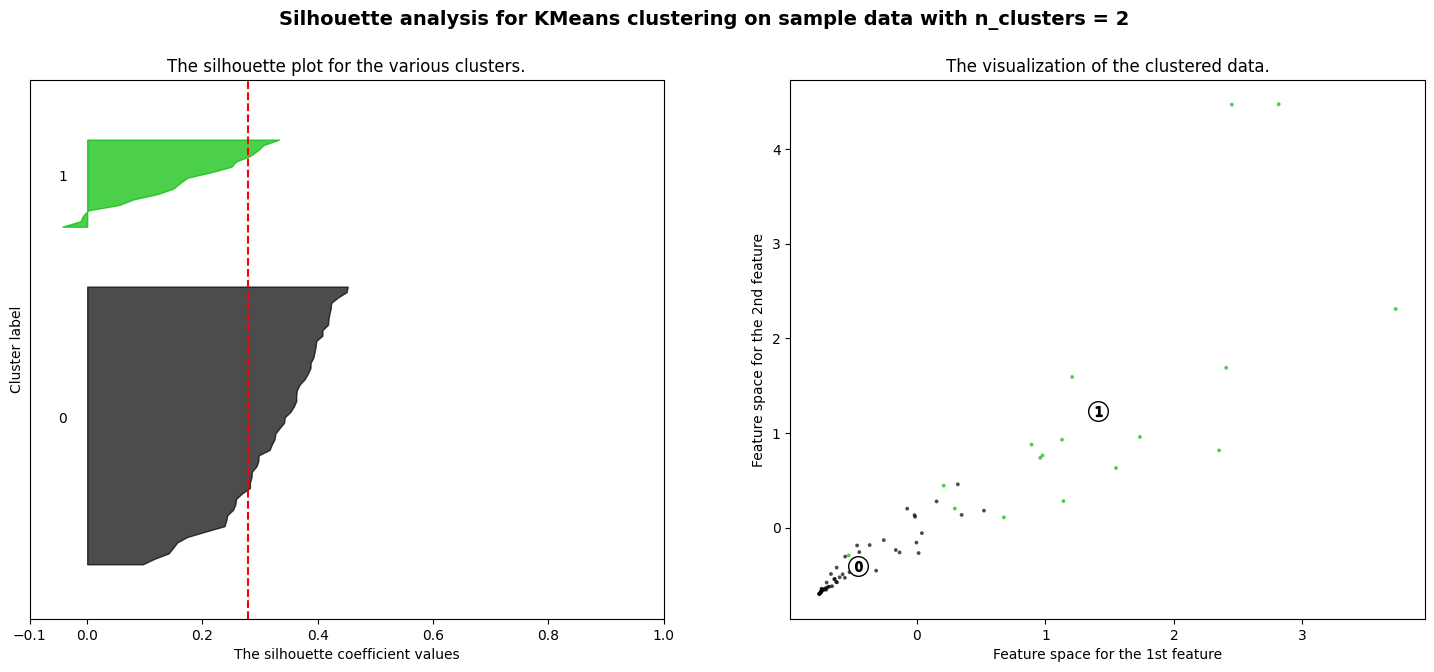

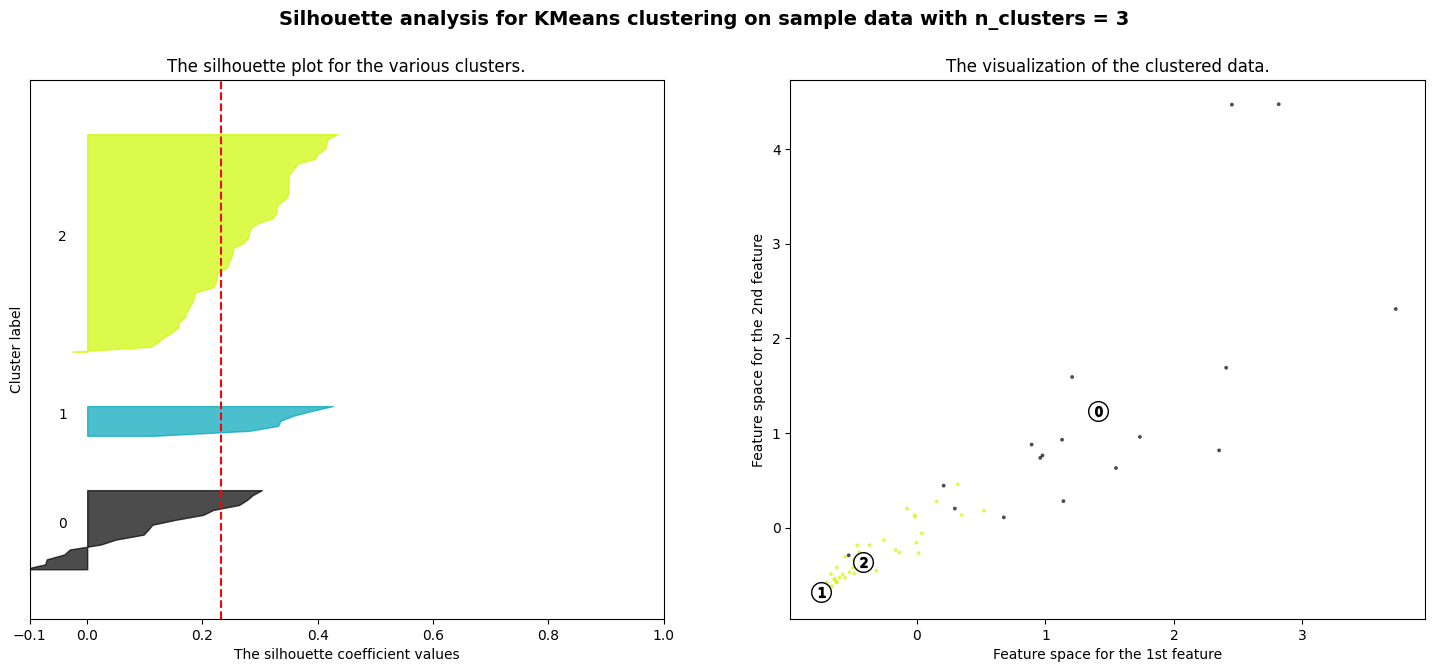

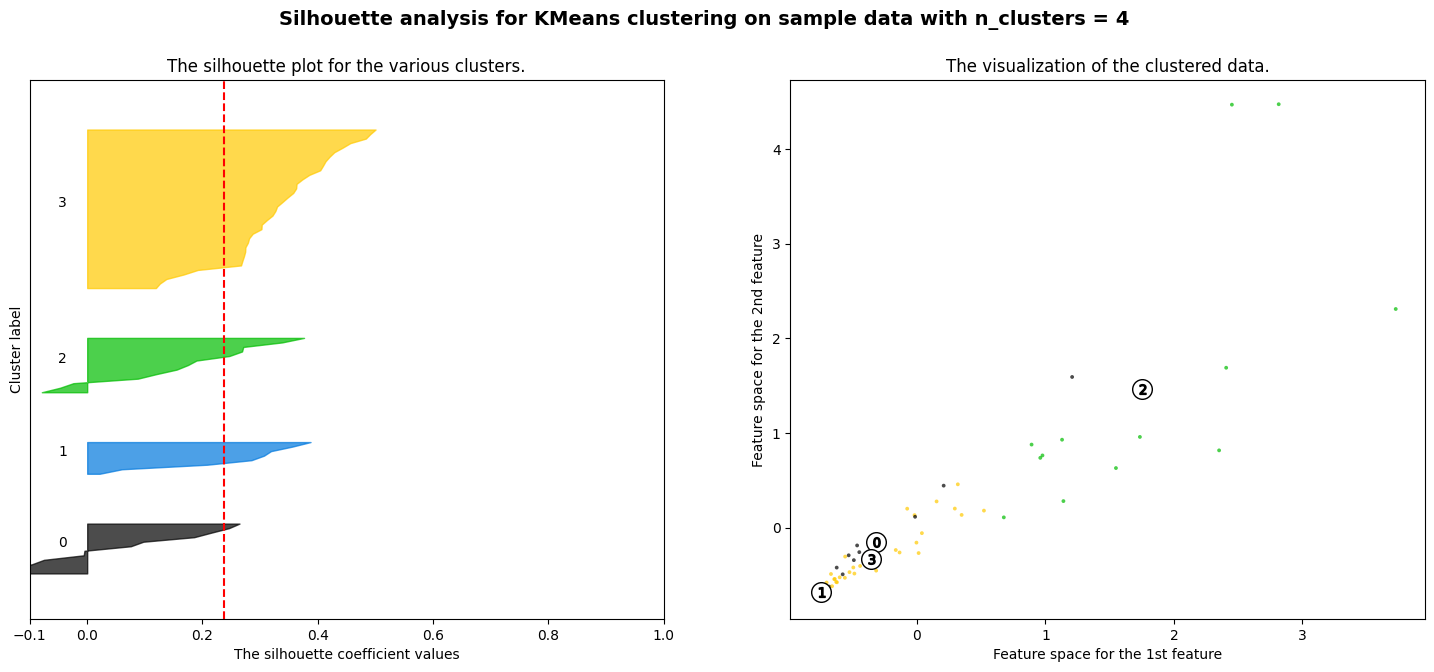

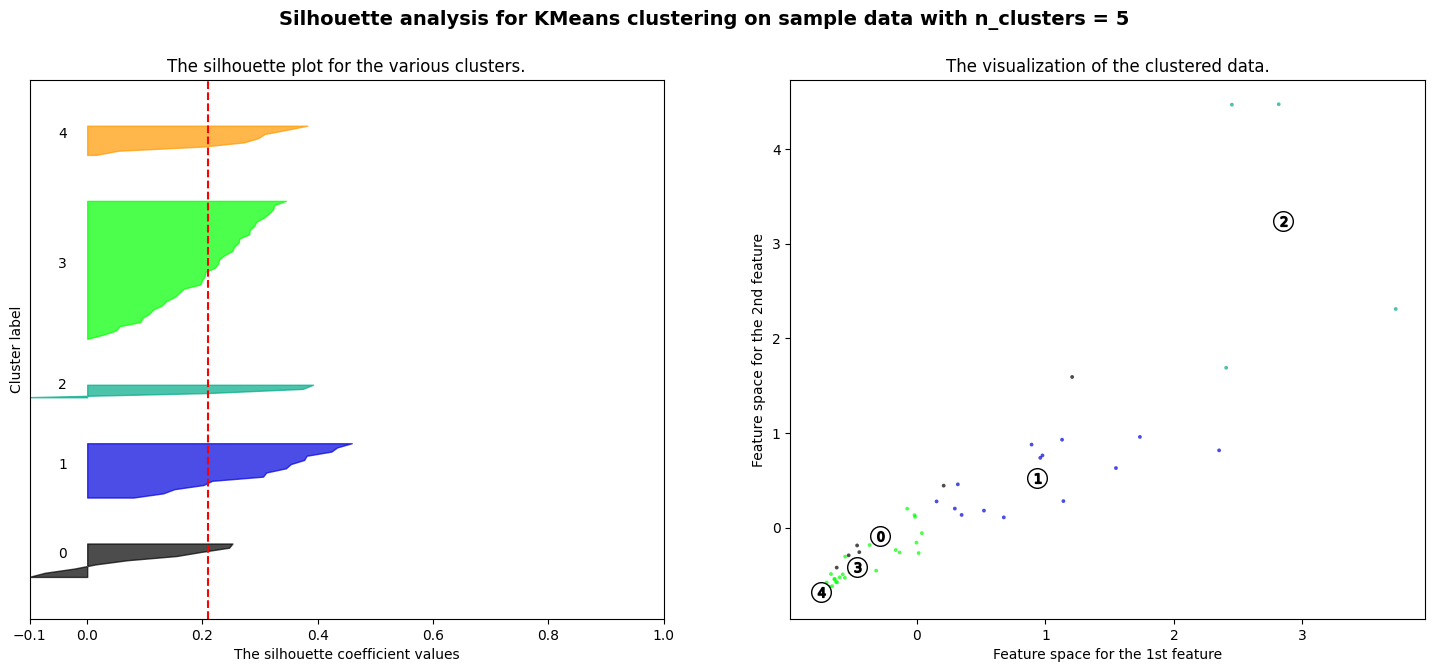

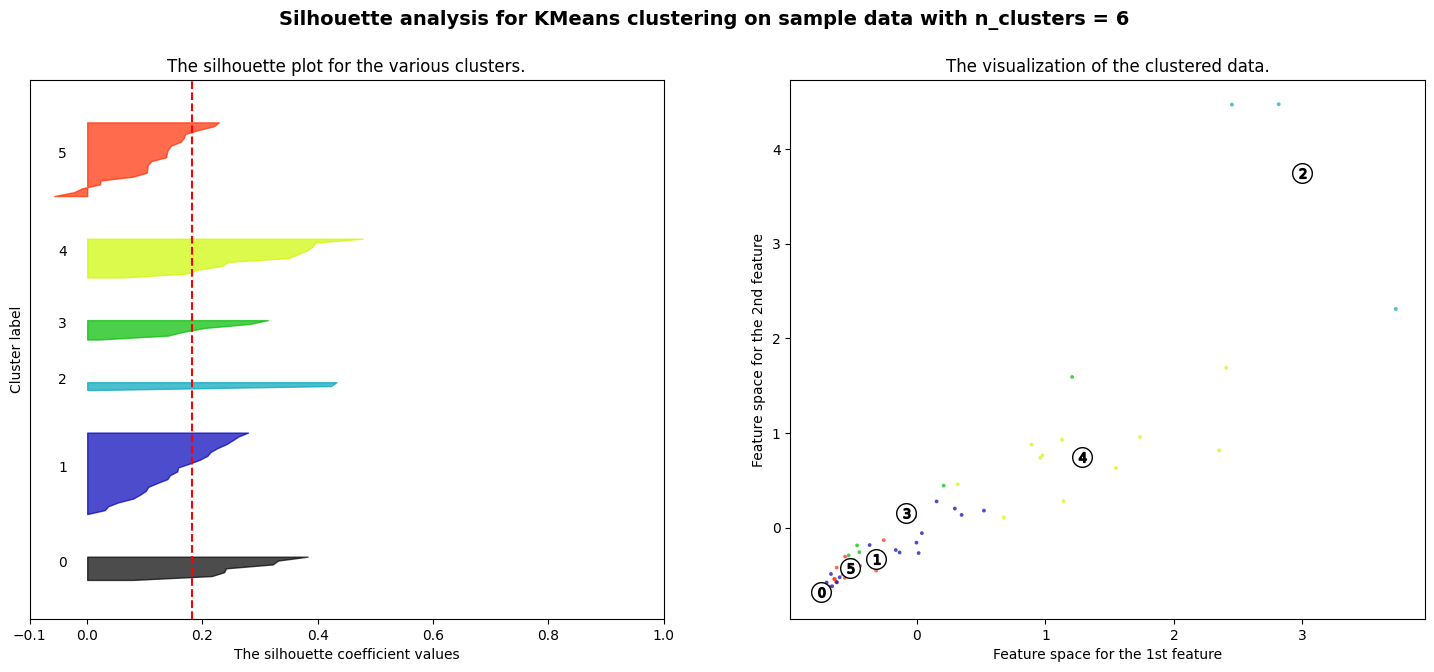

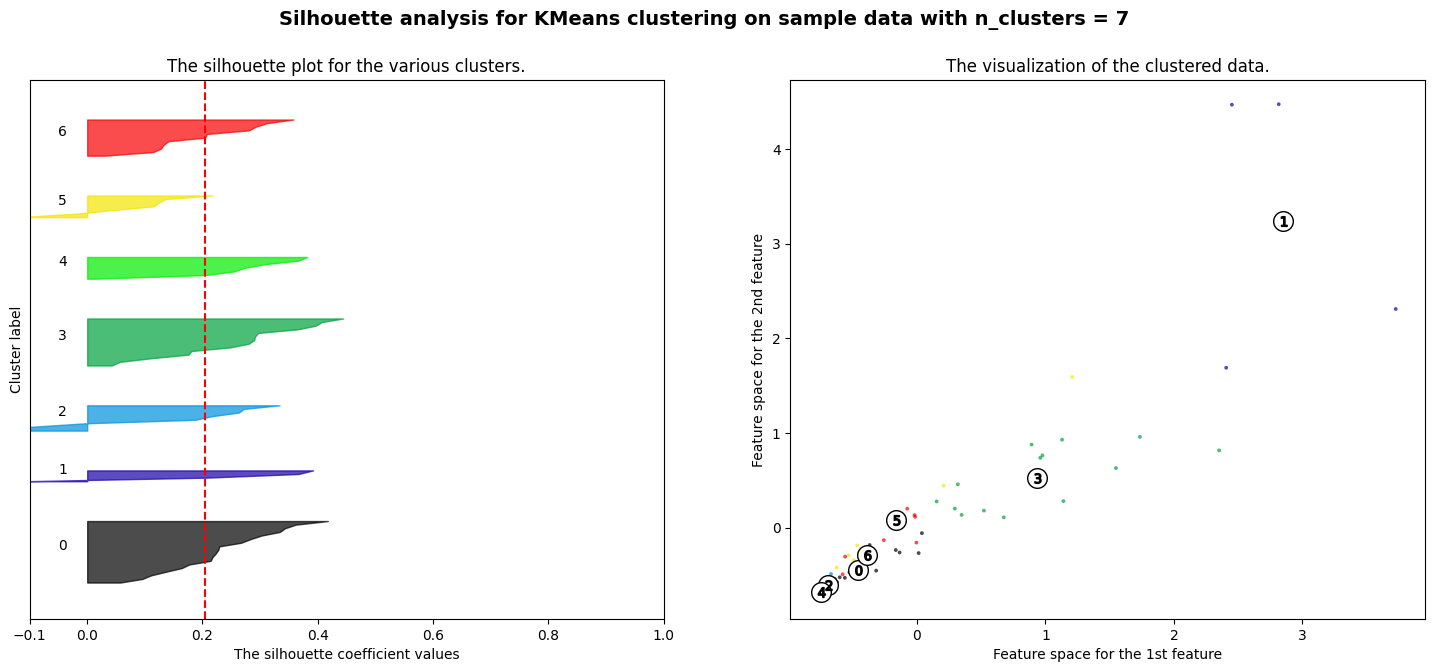

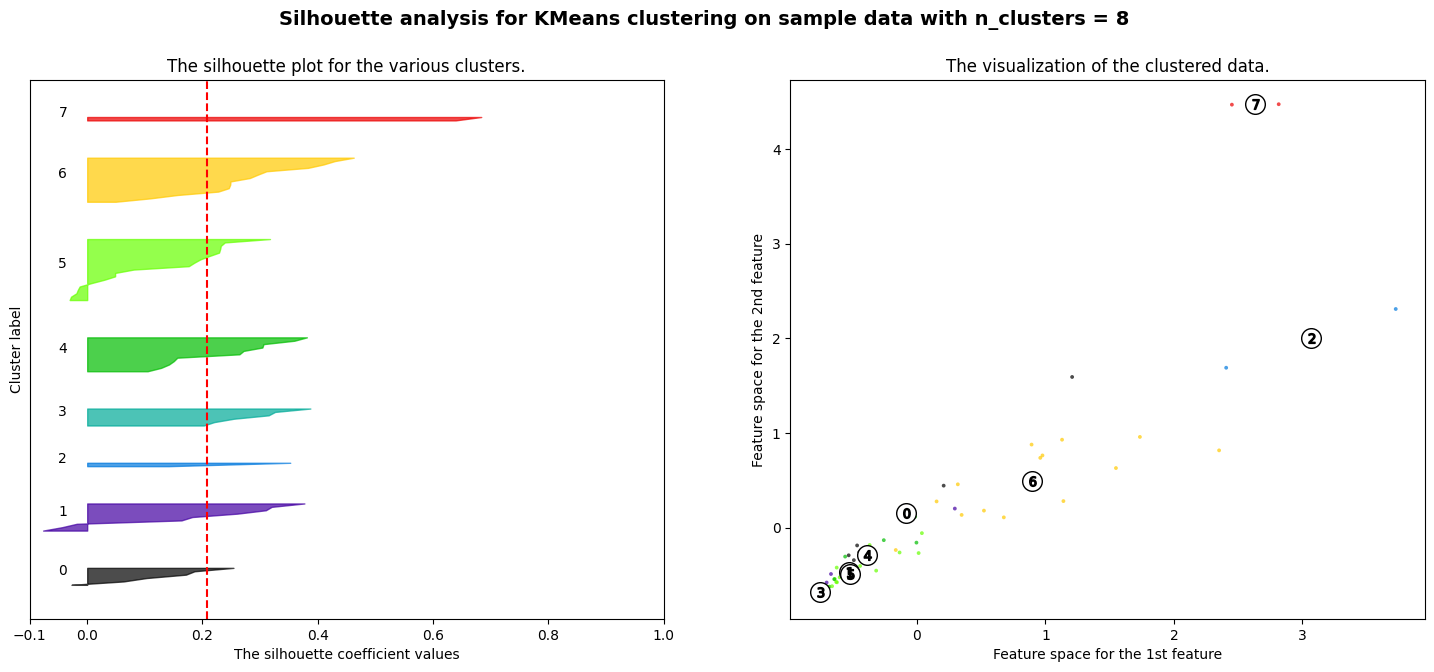

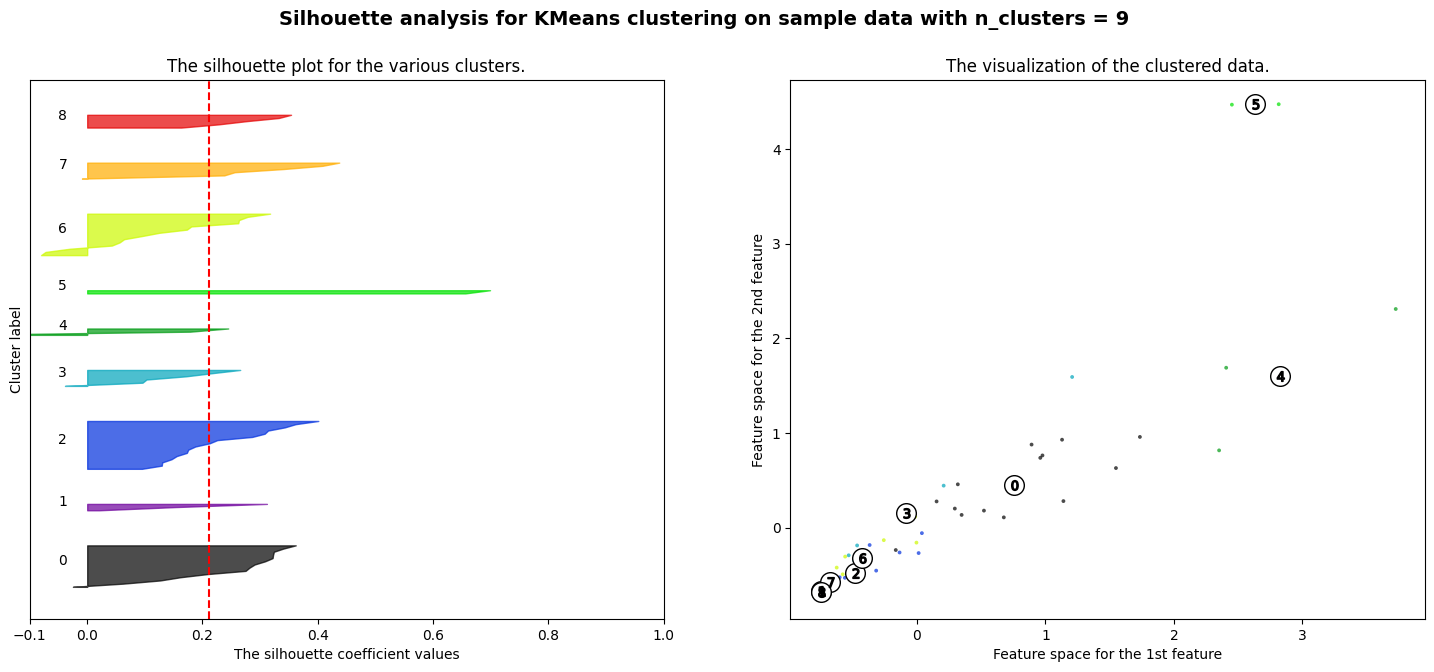

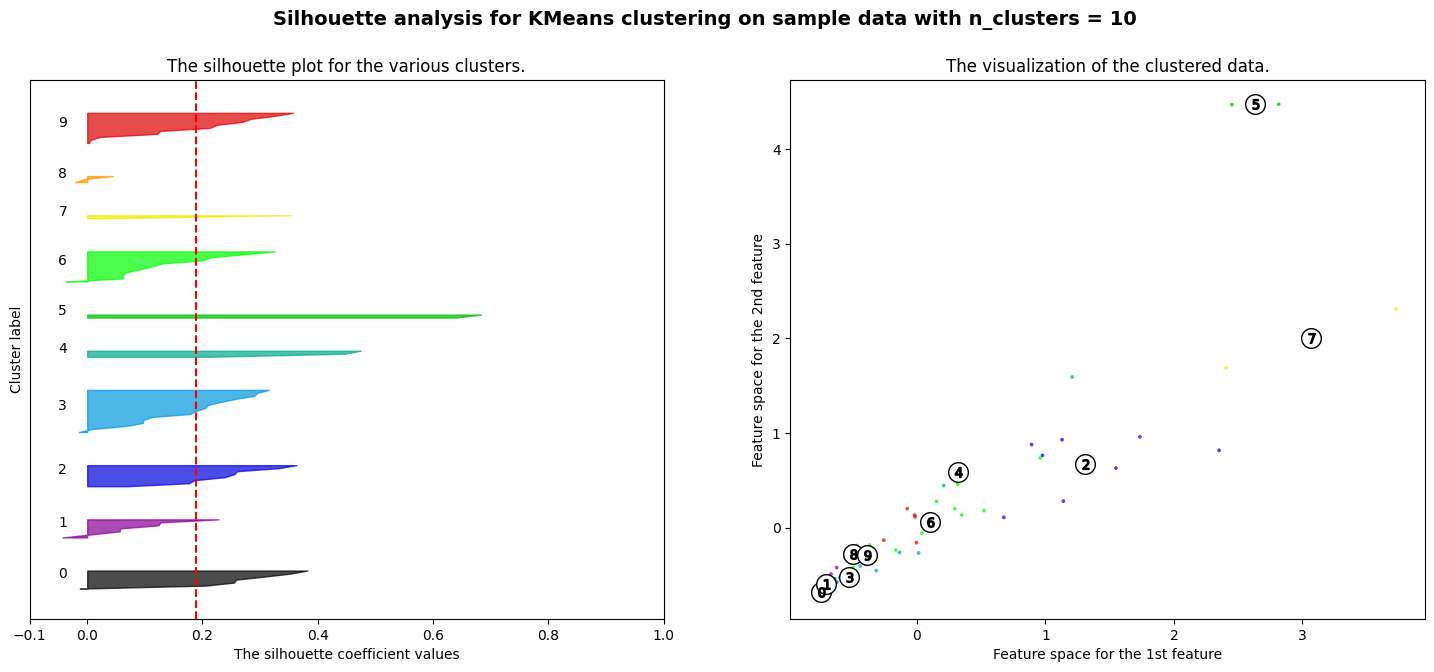

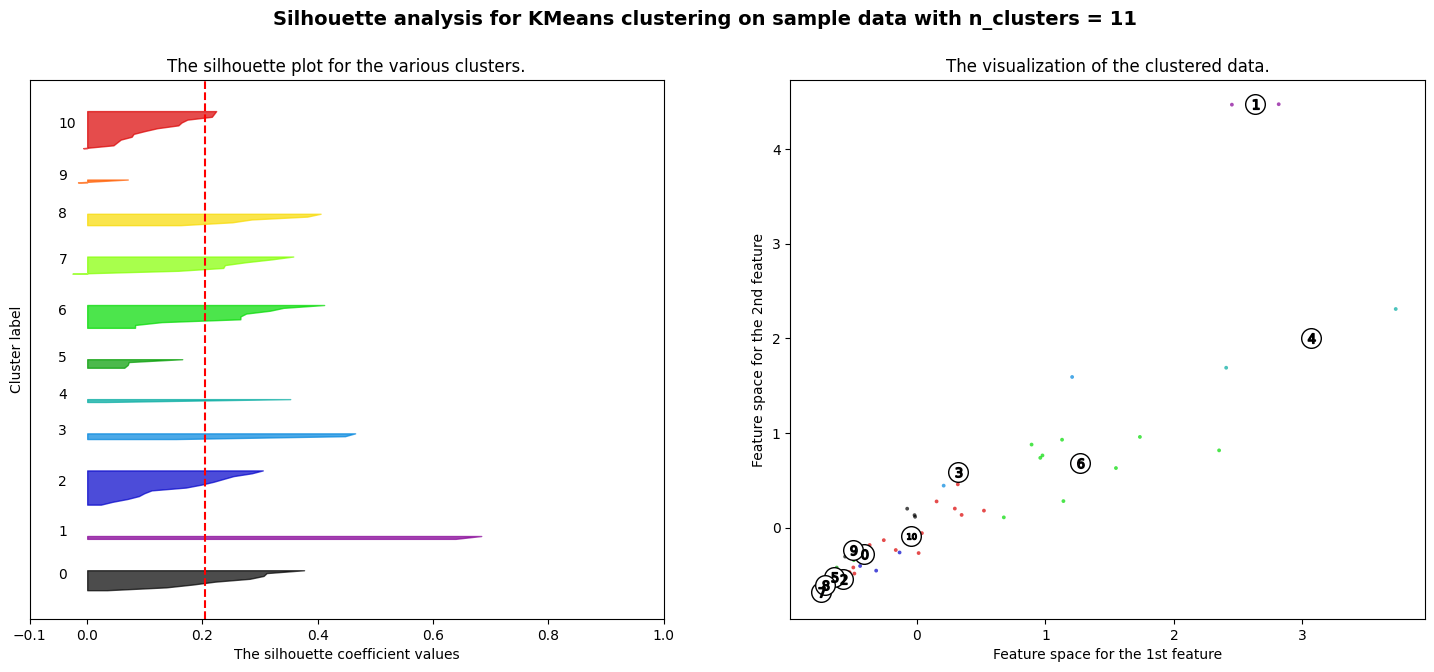

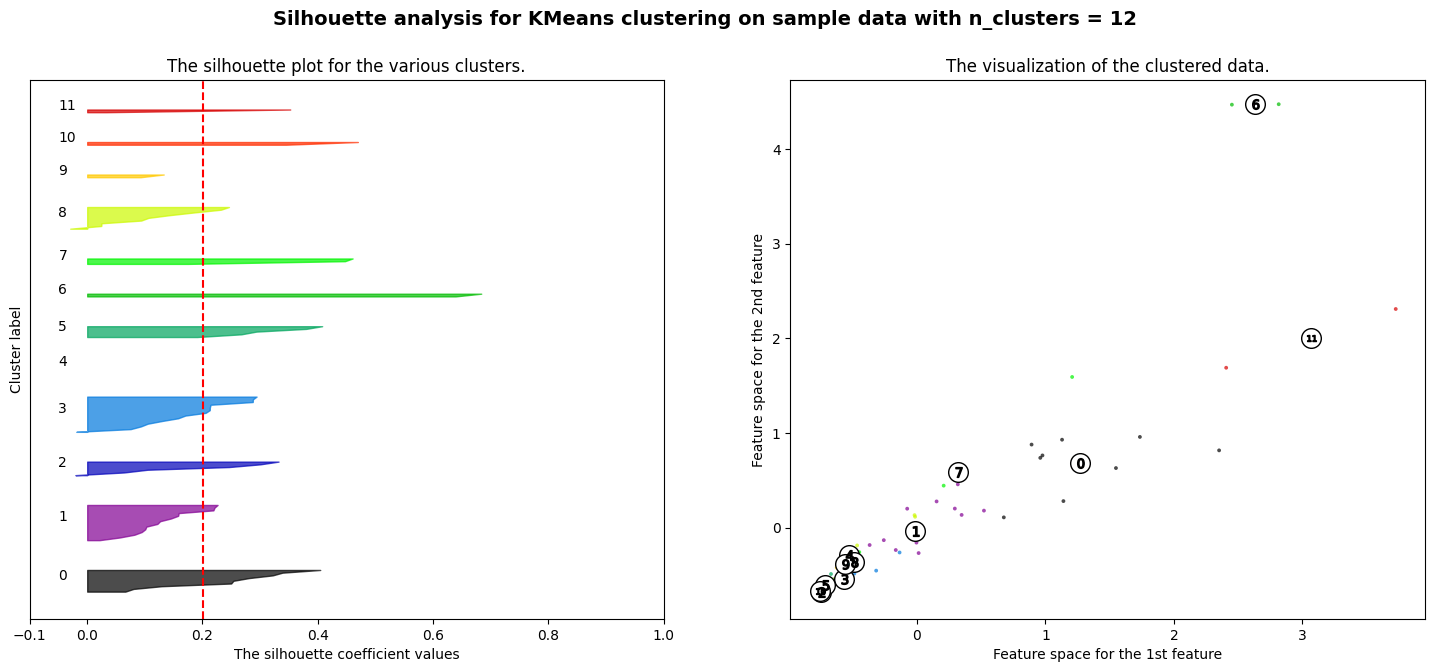

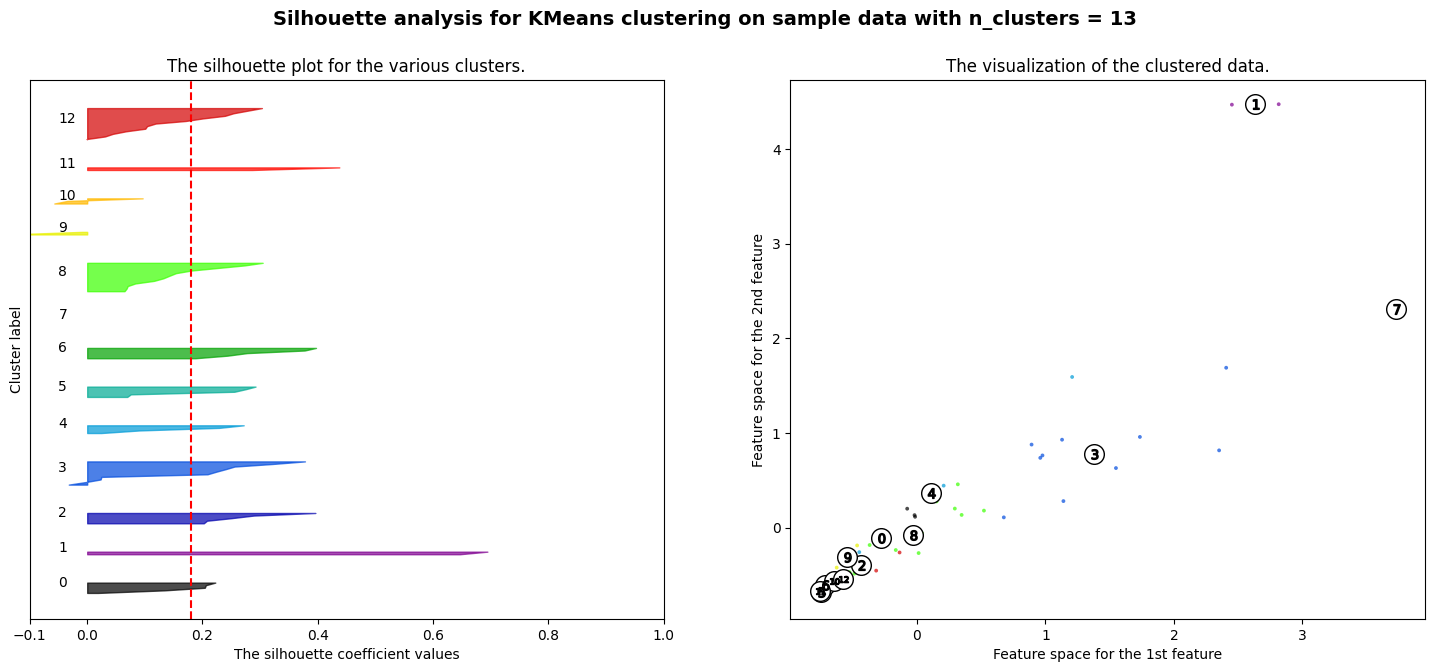

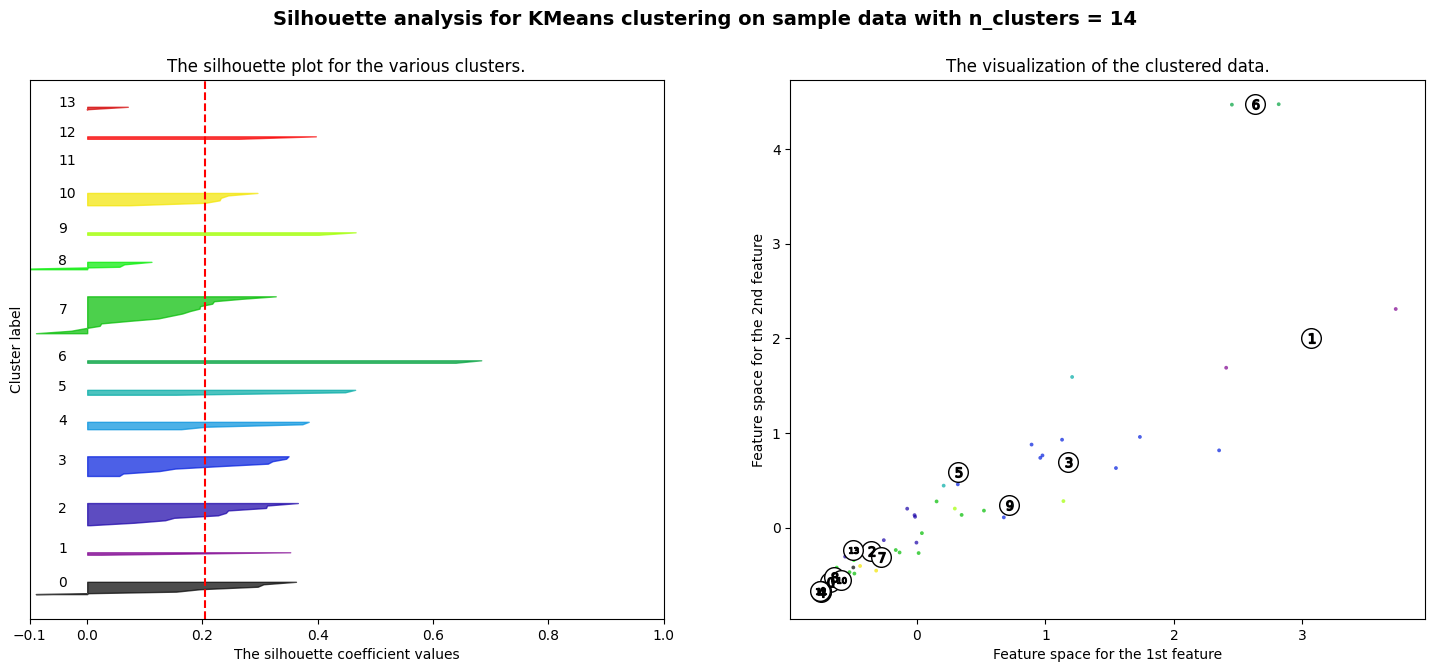

In [29]:
# Define the range of clusters
range_n_clusters = np.arange(2,15)


X = data_scaled.values
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init=10, random_state=10, init = 'k-means++')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [35]:
# Add the new labels and create the new index
new_df = data_scaled.copy().reset_index()
new_df['cluster'] = kmeans_labels
new_df['new_unique_id'] = new_df['cluster'].astype(str) + "_" + new_df['unique_id']
new_df = new_df[['new_unique_id', 'unique_id']]
new_df

,new_unique_id,unique_id
0,3_Audi A1,Audi A1
1,8_Audi A3,Audi A3
2,8_Audi A4,Audi A4
3,3_Audi A5,Audi A5
4,8_Audi A6,Audi A6
...,...,...
64,8_Volkswagen T-Roc,Volkswagen T-Roc
65,0_Volkswagen Tiguan,Volkswagen Tiguan
66,3_Volkswagen Touareg,Volkswagen Touareg
67,8_Volkswagen Touran,Volkswagen Touran


In [36]:
# create the new dataframe!
c_df = sample_df.copy().reset_index()

# Merge with the original dataframe to get the cluster labels
c_df = c_df.merge(new_df, on = 'unique_id', how = 'left')

# drop unique_id, rename new_unique_id to unique_id and set it as index
c_df = c_df.drop(columns = ['unique_id']).rename(columns = {'new_unique_id': 'unique_id'}).set_index('unique_id')
c_df

,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,...,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31
unique_id,,,,,,,,,,,,,,,,,,,,,
3_Audi A1,2.0,21.0,9.0,3.0,5.0,2.0,2.0,1.0,1.0,1.0,...,8.0,2.0,0.0,3.0,0.0,2.0,0.0,2.0,1.0,0.0
8_Audi A3,6.0,45.0,20.0,23.0,13.0,11.0,8.0,9.0,7.0,13.0,...,17.0,11.0,6.0,6.0,3.0,2.0,2.0,4.0,2.0,1.0
8_Audi A4,15.0,60.0,29.0,26.0,16.0,26.0,17.0,13.0,7.0,14.0,...,16.0,8.0,2.0,6.0,2.0,1.0,0.0,2.0,2.0,0.0
3_Audi A5,2.0,11.0,8.0,5.0,4.0,4.0,7.0,7.0,1.0,3.0,...,2.0,2.0,2.0,2.0,0.0,1.0,0.0,2.0,1.0,0.0
8_Audi A6,6.0,30.0,8.0,9.0,5.0,8.0,11.0,3.0,4.0,5.0,...,7.0,1.0,6.0,8.0,4.0,2.0,0.0,3.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8_Volkswagen T-Roc,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,...,8.0,16.0,15.0,10.0,9.0,6.0,2.0,4.0,0.0,4.0
0_Volkswagen Tiguan,1.0,81.0,39.0,16.0,10.0,18.0,13.0,14.0,13.0,29.0,...,7.0,13.0,8.0,10.0,10.0,8.0,8.0,18.0,2.0,5.0
3_Volkswagen Touareg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [43]:
# Initialize Arguments
current = ['Product', 'ID']
correct = ['ID', 'Product']
splitter = '_'
total = True
model = 'ETS'


In [44]:
# Hierarchical forecasting

# Define CHieF
chief = CHieF(bottom_level_freq = freq, h=h, holdout = holdout, cv = cv)

# Fit CHieF -> builds the hierarchical format
chief.fit(df = c_df, current_format=current, corrected_format=correct, splitter=splitter, add_total = total, format = 'pivoted')

# Get all base forecasts
base_forecasts_ets = chief.predict(models = model)
method = 'struc'

# Reconcile
reconciled_forecasts_2 = chief.reconcile(method = method)

# Rename column y_pred to y
reconciled_forecasts_2 = reconciled_forecasts_2.rename(columns = {'y_pred':'y'})

# Add the cross-sectional-level column indicating the hierarchica level
rec_extended = hierarchical_to_transaction(reconciled_forecasts_2, chief.hierarchical_format, sort_by = False, format = 'transaction')
# keep only the bottom level
rec_extended = rec_extended.loc[rec_extended['cross_sectional_level'] == 'ID']
# Split the unique_id on _ and keep the last part
rec_extended['unique_id'] = rec_extended['unique_id'].apply(lambda x: x.split('_')[-1])

# Evaluate
evaluator = Evaluator(sample_df, rec_extended, freq = freq, format = 'pivoted')
eval_df_new = evaluator.evaluate(metrics = metrics).set_index('unique_id')
eval_df_new['rmsse'].mean()

1.7605770325850878

In [52]:
# Find the best number of clusters based on the rmsse on the test set!

range_n_clusters = list(range(5,11))

scores = {}

for n_clusters in range_n_clusters:

    # Cluster and get labels
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(data_scaled)
    
    # Add the new labels and create the new index
    new_df = data_scaled.copy().reset_index()
    new_df['cluster'] = kmeans_labels
    new_df['new_unique_id'] = new_df['cluster'].astype(str) + "_" + new_df['unique_id']
    new_df = new_df[['new_unique_id', 'unique_id']]
    
    # Extend the current dataframe
    c_df = sample_df.copy().reset_index()
    # Merge with the original dataframe to get the cluster labels
    c_df = c_df.merge(new_df, on = 'unique_id', how = 'left')
    # drop unique_id, rename new_unique_id to unique_id and set it as index
    c_df = c_df.drop(columns = ['unique_id']).rename(columns = {'new_unique_id': 'unique_id'}).set_index('unique_id')
    
    # Hierarchical forecasting
    # Define CHieF
    chief = CHieF(bottom_level_freq = freq, h=h, holdout = holdout, cv = cv)
    # Fit CHieF -> builds the hierarchical format
    chief.fit(df = c_df, current_format=current, corrected_format=correct, splitter=splitter, add_total = total, format = 'pivoted')
    # Get all base forecasts
    base_forecasts_ets = chief.predict(models = model)
    method = 'struc'
    # Reconcile
    reconciled_forecasts_2 = chief.reconcile(method = method)
    # Rename column y_pred to y
    reconciled_forecasts_2 = reconciled_forecasts_2.rename(columns = {'y_pred':'y'})
    # Add the cross-sectional-level column indicating the hierarchica level
    rec_extended = hierarchical_to_transaction(reconciled_forecasts_2, chief.hierarchical_format, sort_by = False, format = 'transaction')
    # keep only the bottom level
    rec_extended = rec_extended.loc[rec_extended['cross_sectional_level'] == 'ID']
    # Split the unique_id on _ and keep the last part
    rec_extended['unique_id'] = rec_extended['unique_id'].apply(lambda x: x.split('_')[-1])

    # Evaluate
    evaluator = Evaluator(sample_df, rec_extended, freq = freq, format = 'pivoted')
    eval_df_new = evaluator.evaluate(metrics = metrics).set_index('unique_id')

    # store scores
    scores[n_clusters] = eval_df_new['rmsse'].mean()
    

In [53]:
scores

{5: 1.7238451291916834,
 6: 1.6229755826020067,
 7: 1.6273737086534874,
 8: 1.664167059053941,
 9: 1.7605770325850878,
 10: 1.6238382937203326}

In [54]:
silhouette_scores_important

{5: 0.19471210347315526,
 6: 0.2108190802981213,
 7: 0.21030741460744606,
 8: 0.18513647567460245,
 9: 0.22726836975702644,
 10: 0.19509380646586155}

In [ ]:
# So my assumption is correct!!!
# simmilar clusters => better accuracy!

# we need some dissimiliraty to explain the variability!
# cool

#### Try with different sets of features

In [ ]:
# stepwise featrue selection?
# how many max lages.

In [ ]:
# Will have a dictionary of dictionaries
# Primary keys will be the features
# Secondary keys will be number of levels

# will use Recursive Feature Elimination (RFE): 
# This is a backward selection method but more optimized. 
# It starts with all features, builds a model, ranks features based on their importance, 
# and recursively removes the least important ones.

In [21]:
from typing import List, Tuple, Callable

In [22]:
# First build a function that returns a dictionary with the scores for each level

def level_wise_cross_sectional_reconciliation(scaled_df, level_canditates):
    
    # Initialize a dictionary with the scores
    scores = {}

    for level in level_canditates:

        # build the hierarchical levels and get a copy of the original df
        mapping_df = build_hierarchical_levels(scaled_df, level)
        temp_df = sample_df.copy()

        # Map the index from mapping_df to the new index on sample_df
        mapping_df = mapping_df.set_index('unique_id')
        mapping_df = mapping_df['new_unique_id'].to_dict()
        temp_df.index = temp_df.index.map(mapping_df)

        # Initialize the arguments for hierarhical forecasting
        current = ['Bottom'] + ['level_' + str(i) for i in range(1, level + 1)]
        correct = current.copy()
        splitter = '_'
        total = False
        model = 'ETS'
        method = 'struc'

        # Define CHieF
        chief = CHieF(bottom_level_freq = freq, h=h, holdout = holdout, cv = cv)

        # Fit CHieF -> builds the hierarchical format
        chief.fit(df = temp_df, current_format=current, corrected_format=correct, splitter=splitter, add_total = total, format = 'pivoted')

        # Base forecasts + reconciliation
        base_forecasts_ets = chief.predict(models = model)
        reconciled_forecasts_2 = chief.reconcile(method = method)

        # Rename column y_pred to y
        reconciled_forecasts_2 = reconciled_forecasts_2.rename(columns = {'y_pred':'y'})
        # Add the cross-sectional-level column indicating the hierarchica level
        rec_extended = hierarchical_to_transaction(reconciled_forecasts_2, chief.hierarchical_format, sort_by = False, format = 'transaction')

        # keep only the bottom level
        rec_extended = rec_extended.loc[rec_extended['cross_sectional_level'] == 'Bottom']

        # Split the unique_id on _ and keep the last part
        rec_extended['unique_id'] = rec_extended['unique_id'].apply(lambda x: x.split('_')[-1])

        # Evaluate
        evaluator = Evaluator(sample_df, rec_extended, freq = freq, format = 'pivoted')
        eval_df_new = evaluator.evaluate(metrics = metrics).set_index('unique_id')

        scores[level] = eval_df_new['rmsse'].mean()

    return scores

In [32]:
def build_scaled_df(selected_features):
    
    # build the dataframe with the scaled features
    temp_features = features[selected_features]

    # Scale
    scaler = StandardScaler()
    temp_data_scaled = scaler.fit_transform(temp_features)
    temp_data_scaled = pd.DataFrame(temp_data_scaled, columns=temp_features.columns, index = temp_features.index)

    return temp_data_scaled

In [33]:
# Initialize columns and levels
original_cols =  ['mean','std',  'e_acf1', 'trend', 'linearity', 'curvature', 'seasonal_strength',
        'peak', 'trough', 'entropy', 'lumpiness', 'spike',  'Vchange', 'Lchange']

level_canditates = np.arange(2,12)

In [ ]:

features_ = features[cols]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(features_)
data_scaled = pd.DataFrame(data_scaled, columns=features_.columns, index = features_.index)

In [48]:
# Initialize variables
current_features = set(original_cols)
best_score = float('inf')
best_features = None
level_canditates = np.arange(2,12)
scores_per_feature = {}


# Itterate through the features and resursively eliminate the worst
while current_features:

    # build the scaled df
    temp_data_scaled = build_scaled_df(current_features)

    # Get the scores for each level
    scores = level_wise_cross_sectional_reconciliation(temp_data_scaled, level_canditates)
    # Store
    scores_per_feature[str(current_features)] = scores

    # Take the best score from the dictionary 
    min_score = min(scores.values())

    # If the score is better than the best score
    if min_score < best_score:
        # Update the best score
        best_score = min_score
        # Update the best features
        best_features = current_features.copy()

    # Get the feature with the worst score
    worst_feature = None
    score_without_feature = {}

    # Itterate through the features
    for feature in current_features:
        # remove the feature to measure performance
        temp_features = current_features - {feature}

        # if the feature is not in the dictionary
        if not temp_features:
            continue # skip

        # build the dataframe with the scaled features
        temp_data_scaled = build_scaled_df(temp_features)

        # Get the scores for each level
        scores = level_wise_cross_sectional_reconciliation(temp_data_scaled, level_canditates)

        # Store
        scores_per_feature[str(current_features)] = scores
        score_without_feature[feature] = min(scores.values())

    # Get the feature with the worst score
    worst_feature = min(score_without_feature, key=score_without_feature.get)
    # Remove the worst feature from the current features
    current_features.remove(worst_feature)

    print(f'Worst feature: {worst_feature}')
    print(f'Best score: {best_score}')
    print(f'Best features: {best_features}')
    print(f'Current features: {current_features}')

Worst feature: peak
Best score: 1.595529417660286
Best features: {'mean', 'spike', 'Vchange', 'curvature', 'Lchange', 'linearity', 'lumpiness', 'peak', 'trough', 'trend', 'e_acf1', 'entropy', 'seasonal_strength', 'std'}
Current features: {'mean', 'spike', 'Vchange', 'curvature', 'Lchange', 'linearity', 'lumpiness', 'trough', 'trend', 'e_acf1', 'entropy', 'seasonal_strength', 'std'}


: 

#### Try Dynamic Binning